<a href="https://colab.research.google.com/github/CNIU1997/BA_888/blob/master/888_siqi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data.csv


In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
train = pd.read_csv('train_data.csv',index_col=0)
train = train.iloc[:-2].drop(['X1','PRICE_VAR','year'],axis=1)
train = pd.get_dummies(train, columns=['Sector'])
cols = train.select_dtypes(exclude=['float']).columns
train[cols] = train[cols].apply(pd.to_numeric, downcast='float', errors='coerce')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,224,225,226) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, comp

In [0]:
test = pd.read_csv('test_data.csv',index_col=0)
test = test.iloc[:-2].drop(['X1','PRICE_VAR','year'],axis=1)
test = pd.get_dummies(test, columns=['Sector'])
cols1 = test.select_dtypes(exclude=['float']).columns
test[cols1] = test[cols1].apply(pd.to_numeric, downcast='float', errors='coerce')
# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)

In [0]:
train = (train
     .pipe(lambda df: df.loc[:, df.dtypes.values != np.dtype('O')])) # drop str columns
test = (test
     .pipe(lambda df: df.loc[:, df.dtypes.values != np.dtype('O')]))  # drop str columns

In [0]:
from scipy.stats.mstats import winsorize
## remove outliers 5% higher than the max and 5% lower than the min using for loop and winsorize
for col in train.columns: 
     train[col] = winsorize(train[col], limits=[0.05,0.05])
for col in test.columns: 
     test[col] = winsorize(test[col], limits=[0.05,0.05])

In [5]:
y=train['Class']
X=train.drop(['Class'],axis=1)
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = X.corr().abs()
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

X = X.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', X.shape)
print('Testing shape: ', test.shape)

There are 61 columns to remove.
Training shape:  (17688, 171)
Testing shape:  (4390, 172)


In [0]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [0]:
# modeling 
import lightgbm as lgb
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [9]:
# utilities
from sklearn.model_selection import train_test_split
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.662509	valid_0's auc: 0.647296
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.660438	valid_0's auc: 0.655147


In [10]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
51,Effect_of_forex_changes_on_cash,12.0
13,Gross_Margin,8.5
1,Revenue_Growth,8.5
11,Weighted_Average_Shs_Out,7.5
154,Inventory_Growth,7.0


In [11]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 36 features with 0.0 importance


,feature,importance
30,Total_current_liabilities,0.0
96,freeCashFlowOperatingCashFlowRatio,0.0
147,10Y_Shareholders_Equity_Growth_(per_Share),0.0
28,Payables,0.0
170,Sector_Utilities,0.0


In [0]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


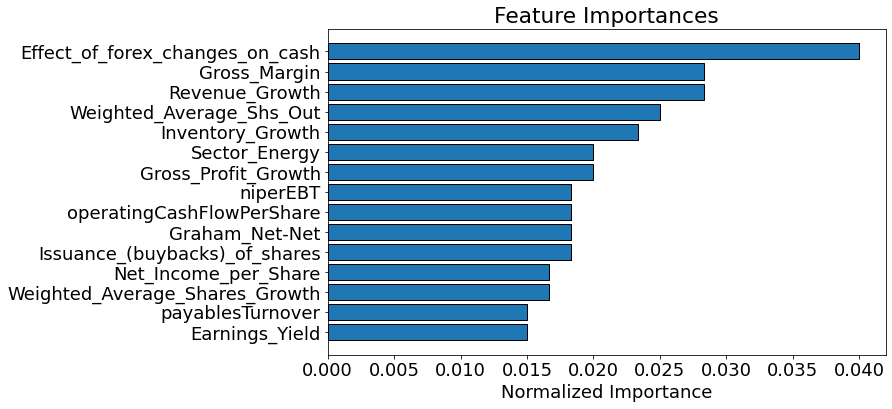

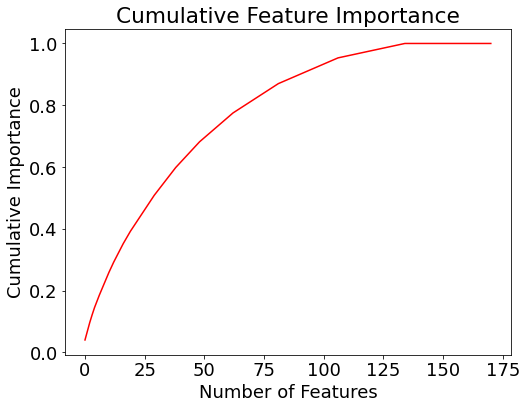

91 features required for 0.90 of cumulative importance


In [13]:
# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

norm_feature_importances = plot_feature_importances(feature_importances)

In [14]:
X1 = X.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', X1.shape)
print('Testing shape: ', test.shape)

Training shape:  (17688, 135)
Testing shape:  (4390, 136)


In [0]:
def identify_zero_importance_features(X1, y, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X1.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(X1, y, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(X1.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [16]:
second_round_zero_features, feature_importances = identify_zero_importance_features(X1, y)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.661546	valid_0's auc: 0.647867
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.658842	valid_0's auc: 0.655477

There are 0 features with 0.0 importance


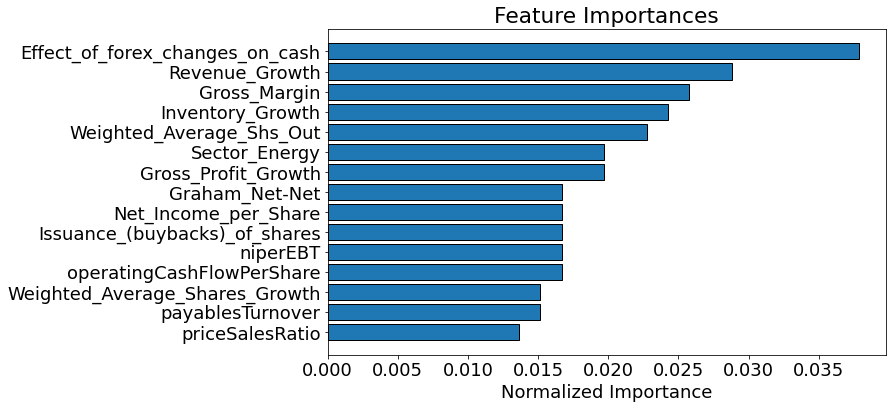

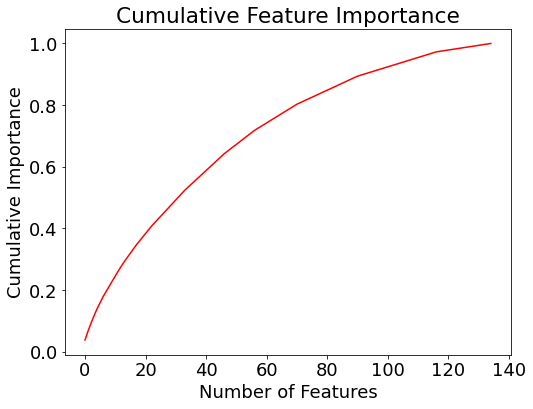

110 features required for 0.95 of cumulative importance


In [17]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [0]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
X_small = X1[features_to_keep]
test_small = test[features_to_keep]

In [0]:
def identify_zero_importance_features(X_small, y, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X_small.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(X_small, y, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(X_small.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

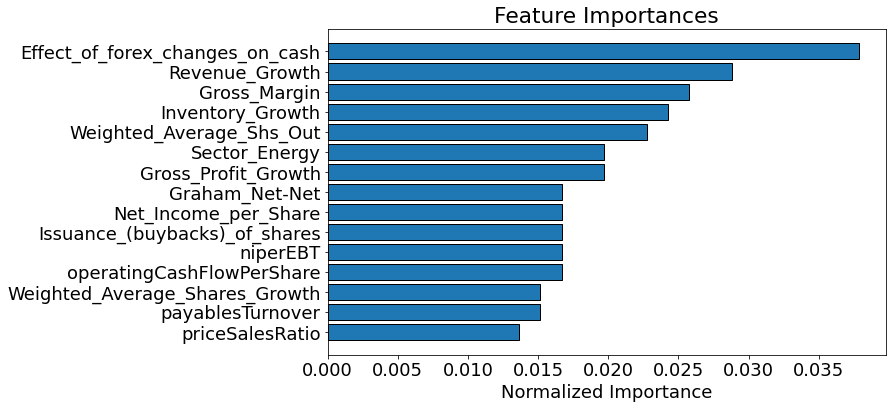

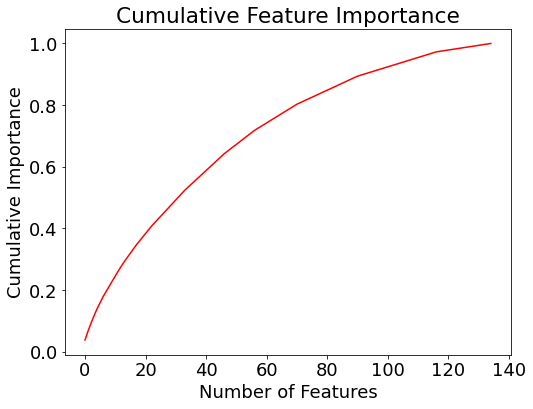

110 features required for 0.95 of cumulative importance


In [20]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [0]:
X_small = pd.DataFrame(X_small)
X_train = X_small.iloc[:,0:15]
cols=['Effect_of_forex_changes_on_cash','Revenue_Growth','Inventory_Growth','Gross_Margin',
      'Weighted_Average_Shs_Out','Weighted_Average_Shares_Growth','Graham_Net-Net',
      'Net_Income_per_Share','Issuance_(buybacks)_of_shares','Sector_Energy','operatingCashFlowPerShare',
      'payablesTurnover','Gross_Profit_Growth','niperEBT','priceSalesRatio']
y_train=train['Class']
X_test=test_small[cols]
y_test=test['Class']


In [38]:
## rbf SVM
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(X_train,y_train)
prediction1=model.predict(X_test)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,y_test))

Accuracy for rbf SVM is  0.6906605922551253


In [0]:
# ## SVM
# model=svm.SVC(kernel='linear',C=0.1,gamma='auto')
# model.fit(X_train,y_train)
# prediction2=model.predict(X_test)
# print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,y_test))

In [40]:
## logistic regression
model = LogisticRegression()
model.fit(X_train,y_train)
prediction3=model.predict(X_test)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,y_test))

The accuracy of the Logistic Regression is 0.4419134396355353


In [41]:
## Decision Tree
model=DecisionTreeClassifier()
model.fit(X_train,y_train)
prediction4=model.predict(X_test)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,y_test))

The accuracy of the Decision Tree is 0.45375854214123007


In [42]:
## KNN
model=KNeighborsClassifier() 
model.fit(X_train,y_train)
prediction5=model.predict(X_test)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,y_test))

The accuracy of the KNN is 0.515489749430524


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


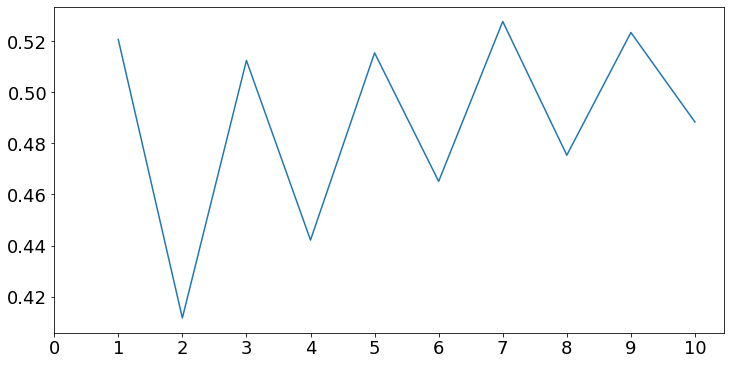

Accuracies for different values of n are: [0.52072893 0.41161731 0.51252847 0.44214123 0.51548975 0.46514806
 0.52779043 0.47539863 0.52346241 0.48838269] with the max value as  0.5277904328018224


In [43]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,y_test)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

In [44]:
## NaiveBayes
model=GaussianNB()
model.fit(X_train,y_train)
prediction6=model.predict(X_test)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,y_test))

The accuracy of the NaiveBayes is 0.32892938496583146


In [45]:
## random forest
model=RandomForestClassifier(n_estimators=200)
model.fit(X_train,y_train)
prediction7=model.predict(X_test)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,y_test))

The accuracy of the Random Forests is 0.35968109339407744


In [22]:
train = pd.read_csv('train_data.csv',index_col=0)
train = train.iloc[:-2].drop(['X1','PRICE_VAR','year'],axis=1)
train = pd.get_dummies(train, columns=['Sector'])
cols = train.select_dtypes(exclude=['float']).columns
train[cols] = train[cols].apply(pd.to_numeric, downcast='float', errors='coerce')

test = pd.read_csv('test_data.csv',index_col=0)
test = test.iloc[:-2].drop(['X1','PRICE_VAR','year'],axis=1)
test = pd.get_dummies(test, columns=['Sector'])
cols1 = test.select_dtypes(exclude=['float']).columns
test[cols1] = test[cols1].apply(pd.to_numeric, downcast='float', errors='coerce')
# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
train = (train
     .pipe(lambda df: df.loc[:, df.dtypes.values != np.dtype('O')])) # drop str columns
test = (test
     .pipe(lambda df: df.loc[:, df.dtypes.values != np.dtype('O')]))  # drop str columns

from scipy.stats.mstats import winsorize
## remove outliers 5% higher than the max and 5% lower than the min using for loop and winsorize
for col in train.columns: 
     train[col] = winsorize(train[col], limits=[0.05,0.05])
for col in test.columns: 
     test[col] = winsorize(test[col], limits=[0.05,0.05])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,224,225,226) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, comp

In [0]:
data = pd.concat([test,train], ignore_index=True)
cols=['Effect_of_forex_changes_on_cash','Revenue_Growth','Inventory_Growth','Gross_Margin',
      'Weighted_Average_Shs_Out','Weighted_Average_Shares_Growth','Graham_Net-Net',
      'Net_Income_per_Share','Issuance_(buybacks)_of_shares','Sector_Energy','operatingCashFlowPerShare',
      'payablesTurnover','Gross_Profit_Growth','niperEBT','priceSalesRatio']
data_y = data['Class']
data_X = data[cols]

In [31]:
## Cross Validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=7),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,data_X,data_y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Radial Svm,0.513567,0.148991
Logistic Regression,0.565796,0.107893
KNN,0.533779,0.065143
Decision Tree,0.517478,0.053453
Naive Bayes,0.499560,0.095936
Random Forest,0.558510,0.078939


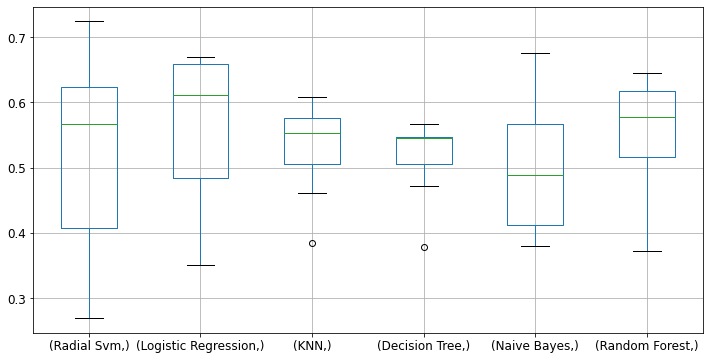

In [36]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot(fontsize=12)

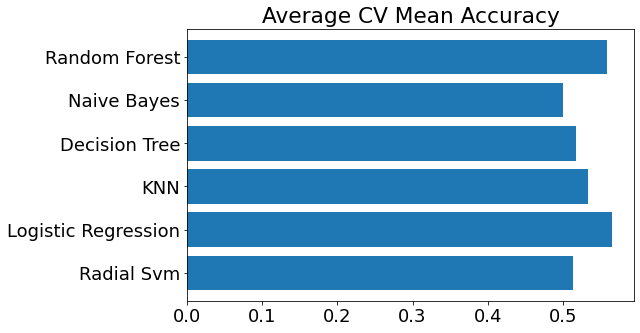

In [37]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

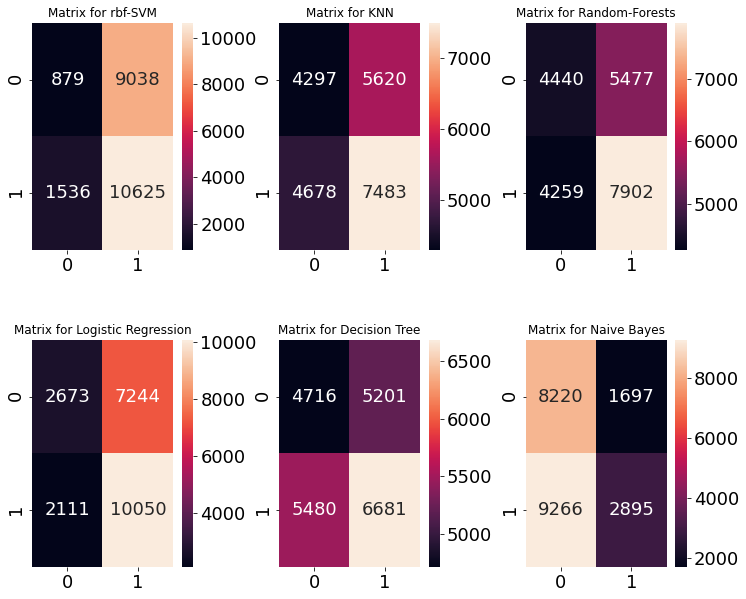

In [40]:
f,ax=plt.subplots(2,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),data_X,data_y,cv=10)
sns.heatmap(confusion_matrix(data_y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM',fontsize= 12)
# y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
# sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
# ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=7),data_X,data_y,cv=10)
sns.heatmap(confusion_matrix(data_y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for KNN',fontsize= 12)
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=200),data_X,data_y,cv=10)
sns.heatmap(confusion_matrix(data_y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for Random-Forests',fontsize= 12)
y_pred = cross_val_predict(LogisticRegression(),data_X,data_y,cv=10)
sns.heatmap(confusion_matrix(data_y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Logistic Regression',fontsize= 12)
y_pred = cross_val_predict(DecisionTreeClassifier(),data_X,data_y,cv=10)
sns.heatmap(confusion_matrix(data_y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Decision Tree',fontsize= 12)
y_pred = cross_val_predict(GaussianNB(),data_X,data_y,cv=10)
sns.heatmap(confusion_matrix(data_y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Naive Bayes',fontsize= 12)
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

In [0]:
## ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
# Instantiate the classfiers and make a list
classifiers = [svm.SVC(kernel='rbf', probability=True),
               LogisticRegression(random_state=1234), 
               KNeighborsClassifier(n_neighbors=7),
               DecisionTreeClassifier(random_state=1234),
               GaussianNB(), 
               RandomForestClassifier(random_state=1234,n_estimators=100)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

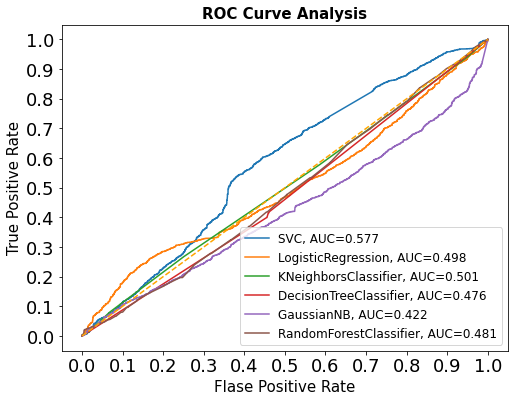

In [48]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':12}, loc='lower right')

plt.show()

In [0]:
# ## choose the 2 best classifers based on the AUC
# ## SVM
# from sklearn.model_selection import GridSearchCV
# C=[0.05,0.1,0.2]
# gamma=[0.1,0.2,0.3]
# kernel=['rbf']
# hyper={'kernel':kernel,'C':C,'gamma':gamma}
# gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
# gd.fit(data_X,data_y)
# print(gd.best_score_)
# print(gd.best_estimator_)

In [0]:
# from sklearn.ensemble import VotingClassifier
# ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
#                                               ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
#                                               ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
#                                               ('LR',LogisticRegression(C=0.05)),
#                                               ('DT',DecisionTreeClassifier(random_state=0)),
#                                               ('NB',GaussianNB()),
#                                              ], 
#                        voting='soft').fit(X_train,y_train)
# print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(X_test,y_test))
# cross=cross_val_score(ensemble_lin_rbf,data_X,data_y, cv = 10,scoring = "accuracy")
# print('The cross validated score is',cross.mean())

In [26]:
## Bagged DecisionTree
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(X_train,y_train)
prediction=model.predict(X_test)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,y_test))
result=cross_val_score(model,data_X,data_y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.40455580865603646
The cross validated score for bagged Decision Tree is: 0.5511743349553134


In [27]:
## AdaBoost(Adaptive Boosting)
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,data_X,data_y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.5683394773218284


In [28]:
## Stochastic Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,data_X,data_y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.5603235628730718


In [29]:
## XGboost
import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,data_X,data_y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.5551150653717093


In [33]:
## Hyper-Parameter Tuning for AdaBoost
from sklearn.model_selection import GridSearchCV
n_estimators=list(range(100,400,100))
learn_rate=[0.05,0.1,0.2,0.3]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(data_X,data_y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  6.4min finished


0.5804836320514715
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None)


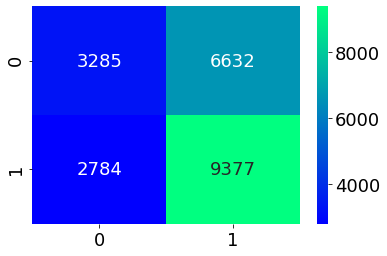

In [34]:
## Confusion Matrix for the Best Model
ada=AdaBoostClassifier(n_estimators=100,random_state=0,learning_rate=0.1)
result=cross_val_predict(ada,data_X,data_y,cv=10)
sns.heatmap(confusion_matrix(data_y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

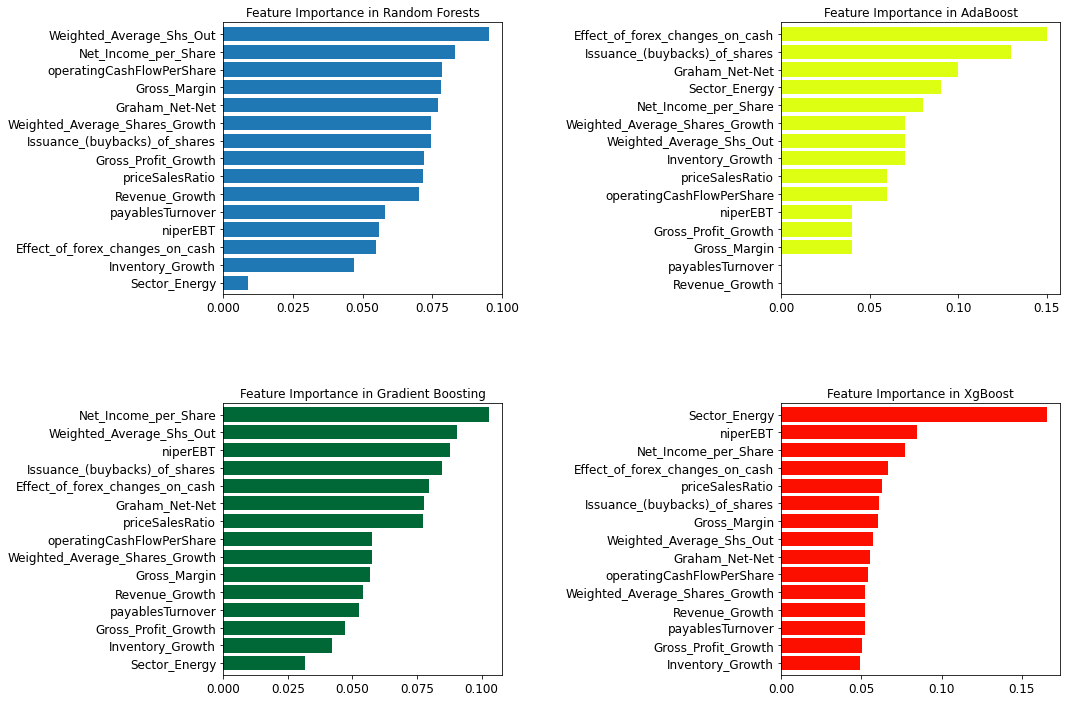

In [37]:
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(data_X,data_y)
pd.Series(model.feature_importances_,data_X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0],fontsize=12)
ax[0,0].set_title('Feature Importance in Random Forests',fontsize=12)
model=AdaBoostClassifier(n_estimators=100,learning_rate=0.1,random_state=0)
model.fit(data_X,data_y)
pd.Series(model.feature_importances_,data_X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11',fontsize=12)
ax[0,1].set_title('Feature Importance in AdaBoost',fontsize=12)
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(data_X,data_y)
pd.Series(model.feature_importances_,data_X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r',fontsize=12)
ax[1,0].set_title('Feature Importance in Gradient Boosting',fontsize=12)
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(data_X,data_y)
pd.Series(model.feature_importances_,data_X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00',fontsize=12)
ax[1,1].set_title('Feature Importance in XgBoost',fontsize=12)
plt.subplots_adjust(hspace=0.4,wspace=1)
plt.show()